In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from thesispy.experiments.dataset import FinishedRun, Dataset

plt.style.use(["science", "high-vis", "../resources/plt_custom.txt"])
api = wandb.Api(timeout=30)
entity = "joasiee"
DEFAULT_WIDTH = 485


def parse_run(run):
    return FinishedRun(
        run.name, run.config, pd.DataFrame.from_dict(run.scan_history())
    )

def get_runs_as_dataset(project, filters={}):
    runs = []
    for run in api.runs(entity + "/" + project, filters=filters):
        runs.append(parse_run(run))
    return Dataset(project, runs)

In [2]:
sampling_ds = Dataset.load("sampling_experiment2")
asgd_sampling = sampling_ds.filter("Optimizer == 'AdaptiveStochasticGradientDescent'")
gomeafull_sampling = sampling_ds.filter("Optimizer == 'GOMEA' AND NOT PartialEvaluations")
gomeapartial_sampling = sampling_ds.filter("Optimizer == 'GOMEA' AND PartialEvaluations")

In [5]:
groups = []
final_evals = []

for group, runs in asgd_sampling.groupby(["SamplingPercentage"]):
    groups.append(group[0])
    evals = []
    for run in runs:
        evals.append(run.resolutions_val[0]["R0/metric"])
    if len(runs) == 4:
        evals.append(np.mean(evals))
    final_evals.append(evals)

groups = [np.around(group,2) for group in groups]
groups, final_evals = zip(*sorted(zip(groups, final_evals)))
asgd_df = pd.DataFrame(np.array(final_evals).transpose(), columns=groups)
asgd_df["Optimizer"] = "ASGD"

In [6]:
frames = [asgd_df, gomeafull_df, gomeapartial_df]
sampling_df = pd.concat(frames)
boxplot_df = pd.melt(sampling_df, id_vars=["Optimizer"], var_name="SamplingPercentage", value_name="MSE")

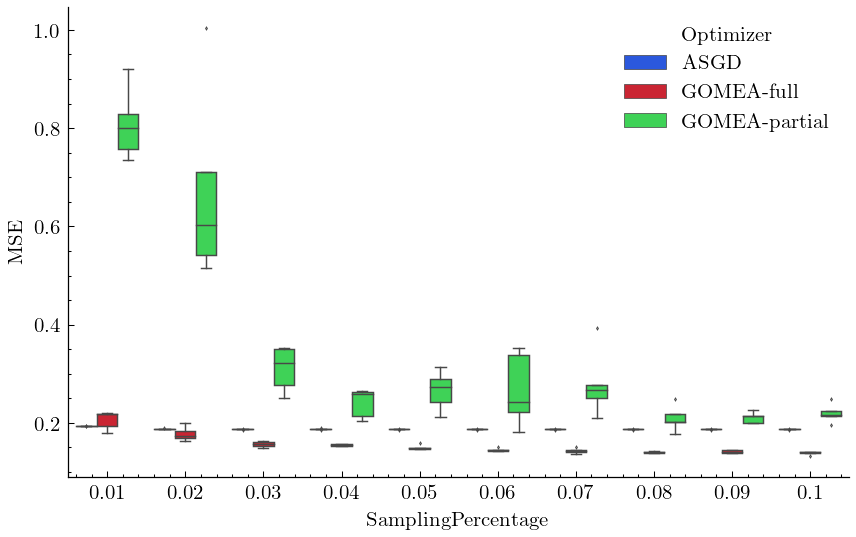

In [14]:
sns.boxplot(x="SamplingPercentage", y="MSE", hue="Optimizer", data=boxplot_df, linewidth=0.7, fliersize=0.25)
plt.savefig("sampling_boxplot_full.png")

In [17]:
def final_full_diff(ds, title):
    groups = []
    final_evals = []

    for group, runs in ds.groupby(["SamplingPercentage"]):
        groups.append(group[0])
        evals = []
        for run in runs:
            evals.append(run.resolutions_val[0]["R0/metric"] - run.resolutions_train[0]["R0/metric"].values[-3])
        if len(runs) == 4:
            evals.append(np.mean(evals))
        final_evals.append(evals)

    groups = [np.around(group,2) for group in groups]
    groups, final_evals = zip(*sorted(zip(groups, final_evals)))
    df = pd.DataFrame(np.array(final_evals).transpose(), columns=groups)
    df["Optimizer"] = title
    return df

In [34]:
frames = [final_full_diff(asgd_sampling, "ASGD"), final_full_diff(gomeafull_sampling, "GOMEA-full"), final_full_diff(gomeapartial_sampling, "GOMEA-partial")]
diff_df = pd.concat(frames)
boxplot_df = pd.melt(diff_df, var_name="SamplingPercentage", value_name="MSE Difference", id_vars=["Optimizer"])
boxplot_df = boxplot_df[["Optimizer", "MSE Difference"]]

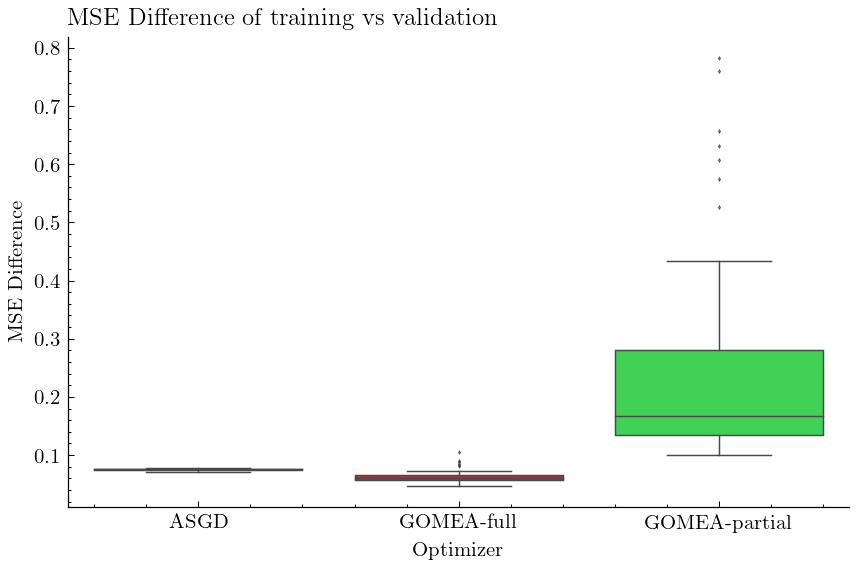

In [38]:
sns.boxplot(x="Optimizer", y="MSE Difference", data=boxplot_df, linewidth=0.7, fliersize=0.25)
plt.title("MSE Difference of training vs validation")
plt.savefig("sampling_diffs.png")
plt.savefig("sampling_diffs.pdf")